Model ที่ดีที่สุด : XGBoost model - SMOTE >>>  f1-score 0.32 (weitghted avg=0.77), AUC = 0.75

ข้อมูล : 2013-2015 (ตัดปี 2011-2012)

ตัวแปร : frequency, total_visit,total_day_visit, monetary_value, ticket_size,  max_year, min_year, active_month, Ticket Size


## **Importing libraries and datasets**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
%cd "/content/sample_data"
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

/content/sample_data


In [4]:
df_response.head()

customer_id  response
0      CS1112         0
1      CS1113         0
2      CS1114         1
3      CS1115         1
4      CS1116         1

In [5]:
df_transactions.head()

customer_id trans_date  tran_amount
0      CS5295 2013-02-11           35
1      CS4768 2015-03-15           39
2      CS2122 2013-02-26           52
3      CS1217 2011-11-16           99
4      CS1850 2013-11-20           78

In [6]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [7]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

customer_id trans_date  tran_amount  recent
0      CS5295 2013-02-11           35   764.0
1      CS4768 2015-03-15           39     2.0
2      CS2122 2013-02-26           52   749.0
3      CS1217 2011-11-16           99  1217.0
4      CS1850 2013-11-20           78   482.0

In [8]:
df_transactions['year'] = df_transactions['trans_date'].dt.strftime('%Y')
df_transactions['month'] = df_transactions['trans_date'].dt.strftime('%m')
df_transactions['year-month'] = df_transactions['trans_date'].dt.strftime('%Y-%m')
df_transactions.head()

customer_id trans_date  tran_amount  recent  year month year-month
0      CS5295 2013-02-11           35   764.0  2013    02    2013-02
1      CS4768 2015-03-15           39     2.0  2015    03    2015-03
2      CS2122 2013-02-26           52   749.0  2013    02    2013-02
3      CS1217 2011-11-16           99  1217.0  2011    11    2011-11
4      CS1850 2013-11-20           78   482.0  2013    11    2013-11

**ตัวแปร:** frequency, total_visit,total_day_visit, monetary_value, ticket_size,  max_year, min_year, active_month, Ticket Size

In [9]:
df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),
                                                     'customer_id': lambda x: len(x),           
                                                    'trans_date' : ['count','nunique'],
                                                    'tran_amount': ['sum','mean','max','min','std'],
                                                    'year': ['max','min','nunique'],
                                                    'year-month' : 'nunique'})
df_rfm.columns = ['recency','frequency','total_visit', 'total_day_visit', 'monetary_value', 
               'ticket_size', 'max_ticket', 'min_ticket','ticket_std', 'max_year', 'min_year','active_year','active_month']

In [10]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

customer_id  recency  frequency  ...  min_year  active_year  active_month
0      CS1112     62.0         15  ...      2011            5            15
1      CS1113     36.0         20  ...      2011            5            18
2      CS1114     33.0         19  ...      2011            5            15
3      CS1115     12.0         22  ...      2011            5            19
4      CS1116    204.0         13  ...      2011            4            13

[5 rows x 14 columns]

In [12]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6889 entries, 0 to 6888
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      6889 non-null   object 
 1   recency          6889 non-null   float64
 2   frequency        6889 non-null   int64  
 3   total_visit      6889 non-null   int64  
 4   total_day_visit  6889 non-null   int64  
 5   monetary_value   6889 non-null   int64  
 6   ticket_size      6889 non-null   float64
 7   max_ticket       6889 non-null   int64  
 8   min_ticket       6889 non-null   int64  
 9   ticket_std       6889 non-null   float64
 10  max_year         6889 non-null   object 
 11  min_year         6889 non-null   object 
 12  active_year      6889 non-null   int64  
 13  active_month     6889 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 753.6+ KB


## **Calculating response rate**

In [13]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

response  customer_id
0         0         6237
1         1          647

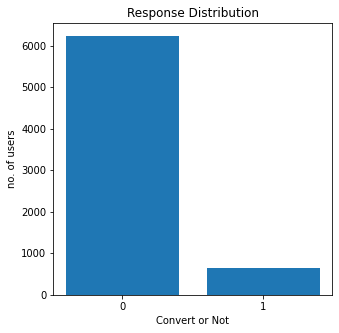

In [14]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [15]:
## merging two data sets

df_modeling = pd.merge(df_response,df_rfm)
df_modeling.head()

customer_id  response  recency  ...  min_year  active_year  active_month
0      CS1112         0     62.0  ...      2011            5            15
1      CS1113         0     36.0  ...      2011            5            18
2      CS1114         1     33.0  ...      2011            5            15
3      CS1115         1     12.0  ...      2011            5            19
4      CS1116         1    204.0  ...      2011            4            13

[5 rows x 15 columns]

In [16]:
# Add Ticket Size
df_rfm['Ticket Size'] = df_rfm.apply(lambda row: row.monetary_value / row.frequency, axis = 1)
df_rfm.head()

customer_id  recency  frequency  ...  active_year  active_month  Ticket Size
0      CS1112     62.0         15  ...            5            15    67.466667
1      CS1113     36.0         20  ...            5            18    74.500000
2      CS1114     33.0         19  ...            5            15    75.368421
3      CS1115     12.0         22  ...            5            19    75.409091
4      CS1116    204.0         13  ...            4            13    65.923077

[5 rows x 15 columns]

In [17]:
#Extract Date
df_transactions['year'] = df_transactions['trans_date'].dt.strftime('%Y')
df_transactions['month'] = df_transactions['trans_date'].dt.strftime('%m')
df_transactions['year-month'] = df_transactions['trans_date'].dt.strftime('%Y-%m')
df_transactions.head()

customer_id trans_date  tran_amount  recent  year month year-month
0      CS5295 2013-02-11           35   764.0  2013    02    2013-02
1      CS4768 2015-03-15           39     2.0  2015    03    2015-03
2      CS2122 2013-02-26           52   749.0  2013    02    2013-02
3      CS1217 2011-11-16           99  1217.0  2011    11    2011-11
4      CS1850 2013-11-20           78   482.0  2013    11    2013-11

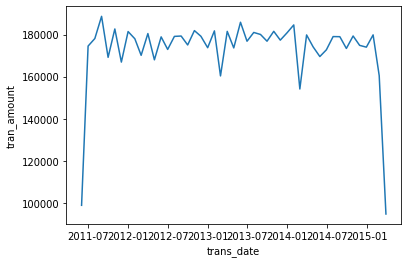

In [18]:
sns.lineplot(x='trans_date', y='tran_amount', data = df_transactions.groupby(by='trans_date')[['tran_amount']].sum().resample('M').sum())

In [19]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


In [21]:
#Use data in 2013-2015 (drop data between 2011 - 2012)
datatime = dt.datetime(2013,1,1)
df_transactions = df_transactions[df_transactions['trans_date']>=datatime]
df_transactions.shape

(71801, 7)

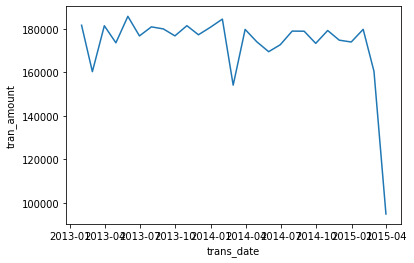

In [22]:
sns.lineplot(x='trans_date', y='tran_amount', data = df_transactions.groupby(by='trans_date')[['tran_amount']].sum().resample('M').sum())

In [23]:
df_modeling = pd.merge(df_response,df_rfm)
df_modeling.head()

customer_id  response  recency  ...  active_year  active_month  Ticket Size
0      CS1112         0     62.0  ...            5            15    67.466667
1      CS1113         0     36.0  ...            5            18    74.500000
2      CS1114         1     33.0  ...            5            15    75.368421
3      CS1115         1     12.0  ...            5            19    75.409091
4      CS1116         1    204.0  ...            4            13    65.923077

[5 rows x 16 columns]

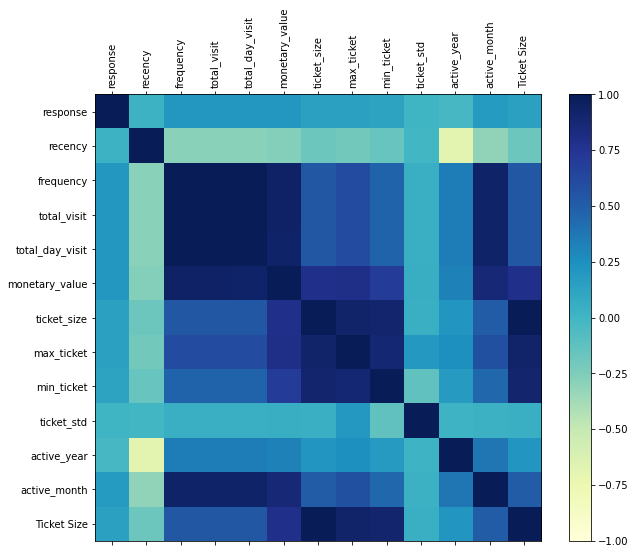

In [24]:
plt.figure(figsize=(10,8))
plt.matshow(df_modeling.corr(),fignum=1)
plt.xticks(range(len(df_modeling.corr().columns)), labels=df_modeling.corr().columns, rotation='vertical')
plt.yticks(range(len(df_modeling.corr().columns)), labels=df_modeling.corr().columns)

plt.imshow(df_modeling.corr(), cmap=plt.cm.get_cmap('YlGnBu', 360))
plt.colorbar()
plt.clim(-1, 1);
plt.show()

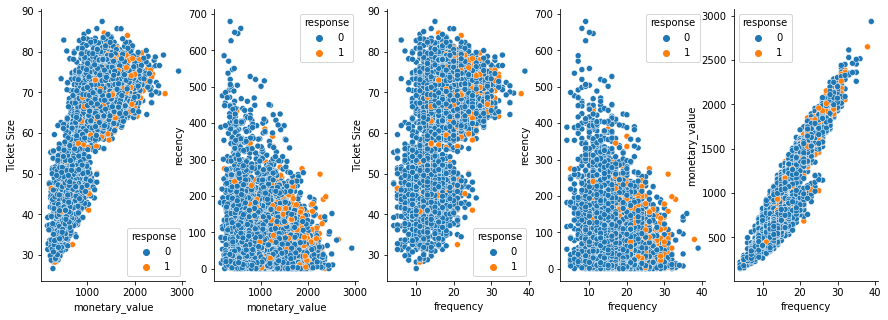

In [25]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
sns.scatterplot(ax=ax[0],data=df_modeling, x='monetary_value', y='Ticket Size',hue='response')
sns.scatterplot(ax=ax[1],data=df_modeling, x='monetary_value', y='recency',hue='response')
sns.scatterplot(ax=ax[2],data=df_modeling, x='frequency', y='Ticket Size',hue='response')
sns.scatterplot(ax=ax[3],data=df_modeling, x='frequency', y='recency',hue='response')
sns.scatterplot(ax=ax[4],data=df_modeling, x='frequency', y='monetary_value',hue='response')
sns.despine()


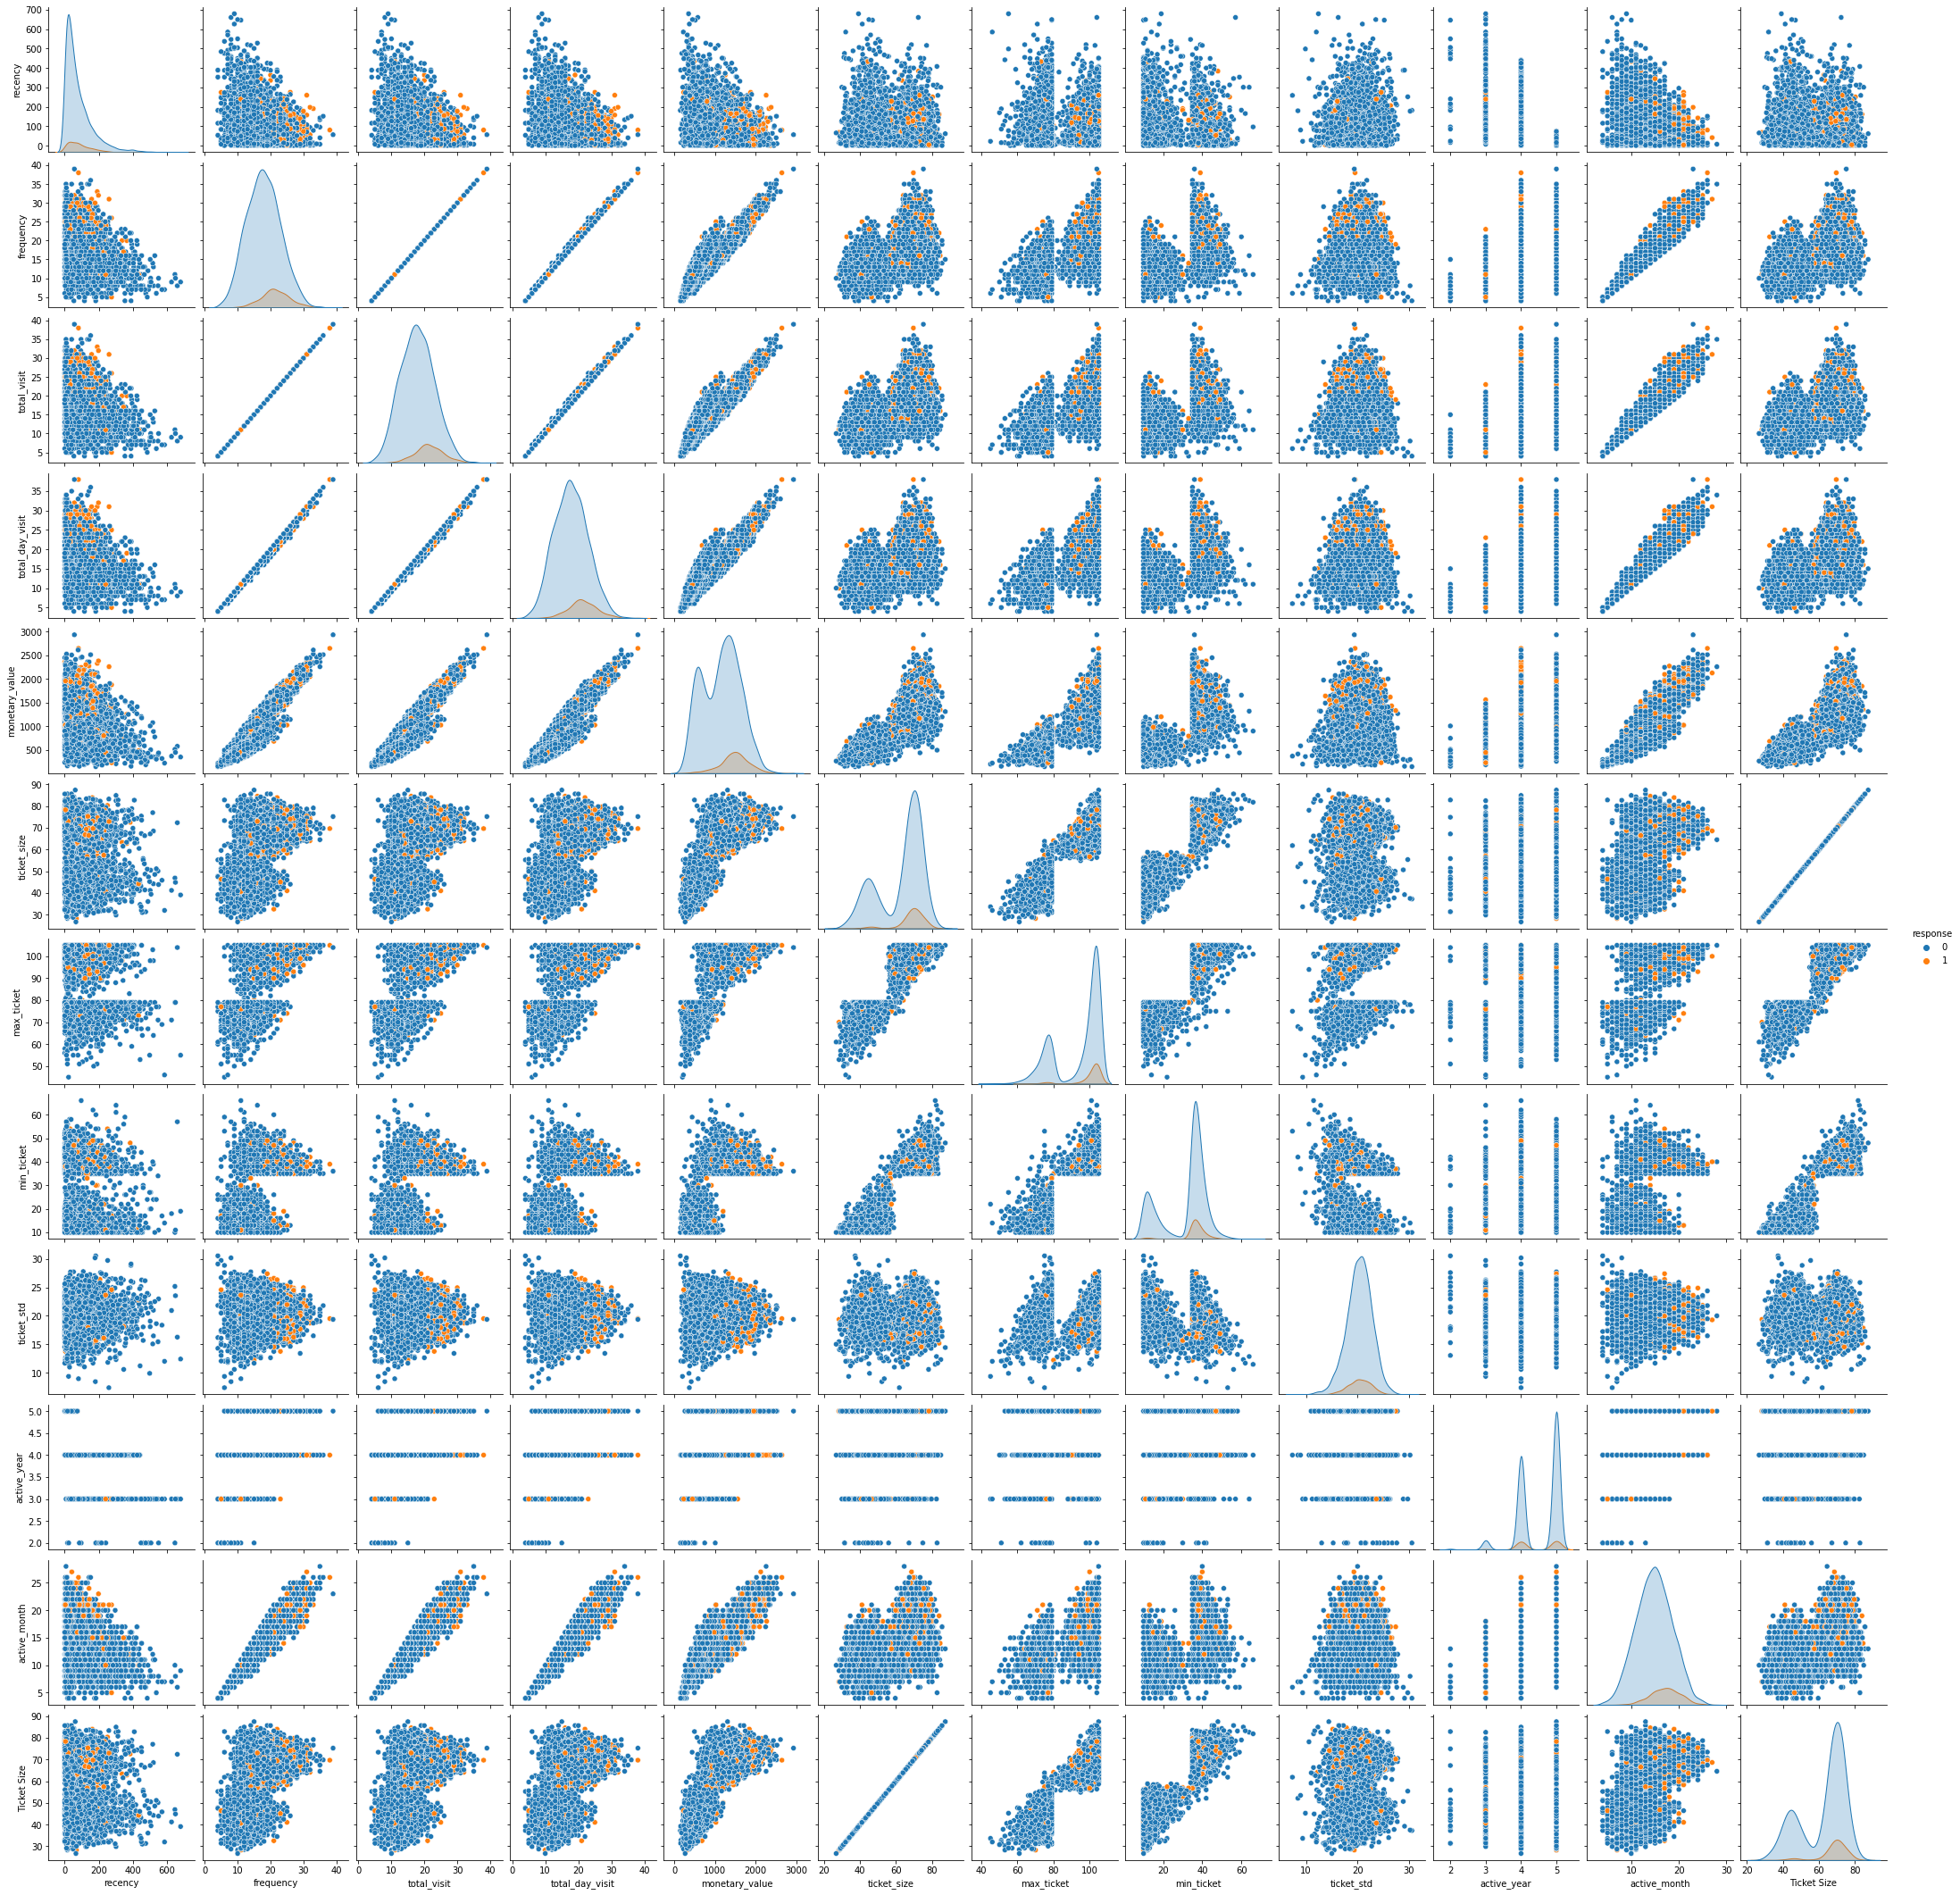

In [ ]:
sns.pairplot(data=df_modeling, hue='response')

In [26]:
df_modeling.columns

Index(['customer_id', 'response', 'recency', 'frequency', 'total_visit',
       'total_day_visit', 'monetary_value', 'ticket_size', 'max_ticket',
       'min_ticket', 'ticket_std', 'max_year', 'min_year', 'active_year',
       'active_month', 'Ticket Size'],
      dtype='object')

## **Creating train and test dataset**

In [27]:
## spliting dataframe into X and y

X = df_modeling.drop(columns=['response','customer_id','recency','active_year','ticket_std','max_ticket','min_ticket'])
y = df_modeling['response']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 9)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 9)
Number transactions y_test dataset:  (2066,)


Text(0.5, 1.0, 'Imbalanced Data')

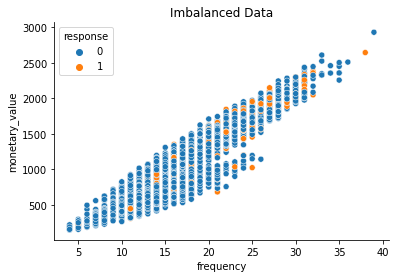

In [29]:
sns.scatterplot(data=df_modeling, x='frequency', y='monetary_value', hue='response')
sns.despine()
plt.title("Imbalanced Data")

## **Fixing imbalanced with Undersampling**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Undersampled Data')

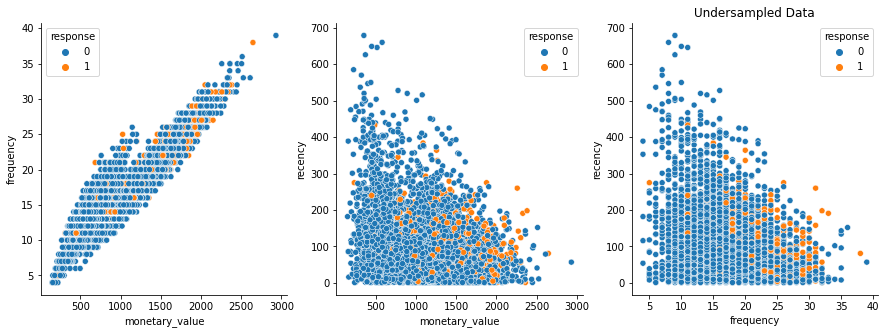

In [30]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= [  'frequency', 'total_visit',
       'total_day_visit', 'monetary_value', 'ticket_size',  'max_year', 'min_year', 'active_month', 'Ticket Size', 'response' ]
    

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(ax=ax[0],data=df_modeling, x='monetary_value', y='frequency',hue='response')
sns.scatterplot(ax=ax[1],data=df_modeling, x='monetary_value', y='recency',hue='response')
sns.scatterplot(ax=ax[2],data=df_modeling, x='frequency', y='recency',hue='response')
sns.despine()
plt.title("Undersampled Data")

## **Fixing imbalanced with Oversampling**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Oversampled Data')

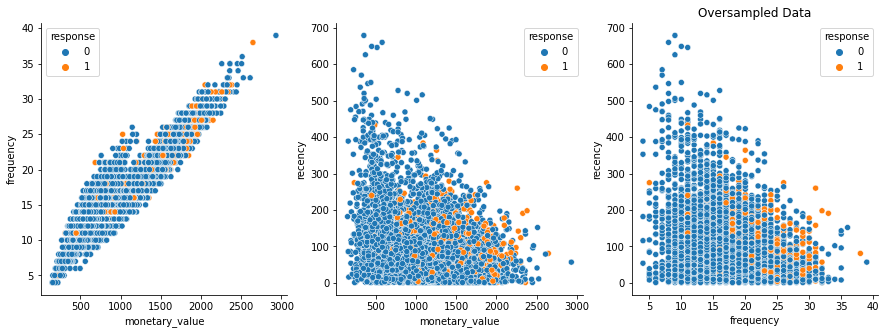

In [31]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= [  'frequency', 'total_visit',
       'total_day_visit', 'monetary_value', 'ticket_size',  'max_year', 'min_year', 'active_month', 'Ticket Size', 'response'  ]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(ax=ax[0],data=df_modeling, x='monetary_value', y='frequency',hue='response')
sns.scatterplot(ax=ax[1],data=df_modeling, x='monetary_value', y='recency',hue='response')
sns.scatterplot(ax=ax[2],data=df_modeling, x='frequency', y='recency',hue='response')
sns.despine()
plt.title("Oversampled Data")

## **Fixing imbalanced with SMOTE**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SMOTE Data')

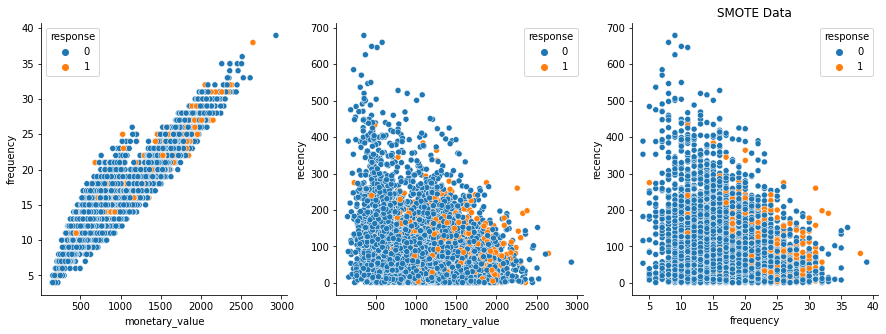

In [32]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= [ 'frequency', 'total_visit',
       'total_day_visit', 'monetary_value', 'ticket_size',  'max_year', 'min_year', 'active_month', 'Ticket Size', 'response'   ]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(ax=ax[0],data=df_modeling, x='monetary_value', y='frequency',hue='response')
sns.scatterplot(ax=ax[1],data=df_modeling, x='monetary_value', y='recency',hue='response')
sns.scatterplot(ax=ax[2],data=df_modeling, x='frequency', y='recency',hue='response')
sns.despine()
plt.title("SMOTE Data")

## **Logistic Regression Model**

In [33]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.71      0.61      0.65       429
           1       0.66      0.75      0.70       429

    accuracy                           0.68       858
   macro avg       0.68      0.68      0.68       858
weighted avg       0.68      0.68      0.68       858

test set
              precision    recall  f1-score   support

           0       0.96      0.57      0.72      1848
           1       0.18      0.81      0.30       218

    accuracy                           0.60      2066
   macro avg       0.57      0.69      0.51      2066
weighted avg       0.88      0.60      0.67      2066



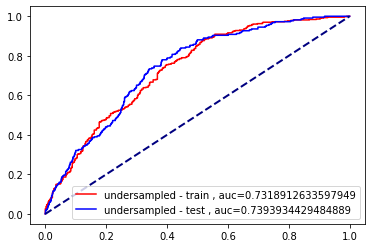

In [34]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [35]:
print(logreg_model_under.coef_, logreg_model_under.intercept_)

[[ 0.10694516  0.10694516  0.05957861 -0.00157212  0.03409336 -0.54326066
   0.54060397 -0.03239531  0.03409336]] [0.00022228]


In [36]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.69      0.59      0.64      4389
           1       0.64      0.74      0.69      4389

    accuracy                           0.66      8778
   macro avg       0.67      0.66      0.66      8778
weighted avg       0.67      0.66      0.66      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.58      0.72      1848
           1       0.18      0.79      0.29       218

    accuracy                           0.60      2066
   macro avg       0.57      0.68      0.51      2066
weighted avg       0.88      0.60      0.68      2066



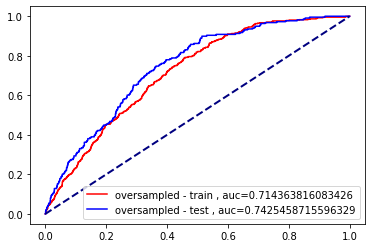

In [37]:
y_score_train = logreg_model_over.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_over.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [38]:
print(logreg_model_over.coef_, logreg_model_under.intercept_)

[[ 0.1272313   0.1272313   0.03583351 -0.00244486  0.03717205 -0.55217734
   0.54931525  0.02036348  0.03717205]] [0.00022228]


In [39]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.69      0.60      0.64      4389
           1       0.65      0.73      0.69      4389

    accuracy                           0.67      8778
   macro avg       0.67      0.67      0.67      8778
weighted avg       0.67      0.67      0.67      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.59      0.73      1848
           1       0.18      0.78      0.30       218

    accuracy                           0.61      2066
   macro avg       0.57      0.69      0.52      2066
weighted avg       0.88      0.61      0.69      2066



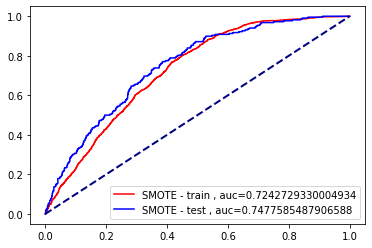

In [40]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [41]:
print(logreg_model_SMOTE.coef_, logreg_model_under.intercept_)

[[ 0.09814526  0.09814526  0.13065823 -0.00276686  0.04203709 -0.74726977
   0.74431723  0.01583285  0.04203709]] [0.00022228]


## **XGBoost**

In [42]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_under = xgb_model.fit(X_undersampled, y_undersampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('XGBoost model - undersampled')
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - undersampled
[0]	validation_0-auc:0.714915
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.721314
[2]	validation_0-auc:0.725385
[3]	validation_0-auc:0.720516
[4]	validation_0-auc:0.72134
[5]	validation_0-auc:0.724316
[6]	validation_0-auc:0.724009
[7]	validation_0-auc:0.724272
Stopping. Best iteration:
[2]	validation_0-auc:0.725385

XGBoost model - undersampled
training set
              precision    recall  f1-score   support

           0       0.76      0.57      0.65       429
           1       0.66      0.82      0.73       429

    accuracy                           0.70       858
   macro avg       0.71      0.70      0.69       858
weighted avg       0.71      0.70      0.69       858

test set
              precision    recall  f1-score   support

           0       0.96      0.51      0.67      1848
           1       0.16      0.81      0.27       218

    accuracy                           0.55      2066
   macro avg    

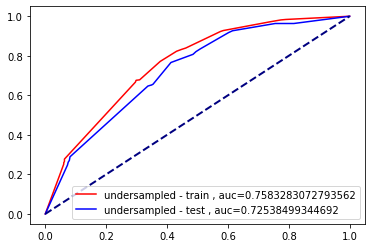

In [43]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

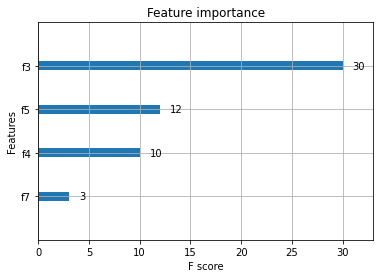

In [44]:
xgb.plot_importance(xgb_model_under)

In [45]:
print('XGBoost model - oversampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_over = xgb_model.fit(X_oversampled, y_oversampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('XGBoost model - oversampled')
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_over.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - oversampled
[0]	validation_0-auc:0.716341
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.712925
[2]	validation_0-auc:0.715408
[3]	validation_0-auc:0.713584
[4]	validation_0-auc:0.71803
[5]	validation_0-auc:0.719683
[6]	validation_0-auc:0.718604
[7]	validation_0-auc:0.719999
[8]	validation_0-auc:0.720855
[9]	validation_0-auc:0.722679
[10]	validation_0-auc:0.722751
[11]	validation_0-auc:0.716216
[12]	validation_0-auc:0.715159
[13]	validation_0-auc:0.712077
[14]	validation_0-auc:0.712609
[15]	validation_0-auc:0.713015
Stopping. Best iteration:
[10]	validation_0-auc:0.722751

XGBoost model - oversampled
training set
              precision    recall  f1-score   support

           0       0.74      0.56      0.64      4389
           1       0.65      0.80      0.72      4389

    accuracy                           0.68      8778
   macro avg       0.69      0.68      0.68      8778
weighted avg       0.69      0.68      0.68      8778

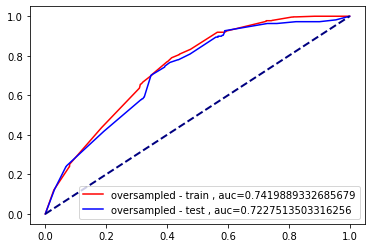

In [46]:
y_score_train = xgb_model_over.predict_proba(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = xgb_model_over.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

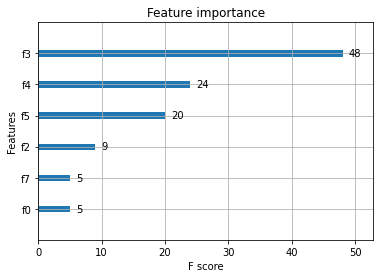

In [47]:
xgb.plot_importance(xgb_model_over)

## **XGBoost model - SMOTE' เป็น Model ที่ดีที่สุด f1-score 0.32 (weighted avg=0.77) AUC = 0.75** 

In [48]:
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('XGBoost model - SMOTE')
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE
[0]	validation_0-auc:0.693991
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.693991
[2]	validation_0-auc:0.741434
[3]	validation_0-auc:0.703373
[4]	validation_0-auc:0.703306
[5]	validation_0-auc:0.747005
[6]	validation_0-auc:0.749279
[7]	validation_0-auc:0.749623
[8]	validation_0-auc:0.750174
[9]	validation_0-auc:0.750626
[10]	validation_0-auc:0.742808
[11]	validation_0-auc:0.743969
[12]	validation_0-auc:0.739273
[13]	validation_0-auc:0.733313
[14]	validation_0-auc:0.730311
Stopping. Best iteration:
[9]	validation_0-auc:0.750626

XGBoost model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.78      0.73      0.75      4389
           1       0.74      0.80      0.77      4389

    accuracy                           0.76      8778
   macro avg       0.76      0.76      0.76      8778
weighted avg       0.76      0.76      0.76      8778

test set
              precision    recal

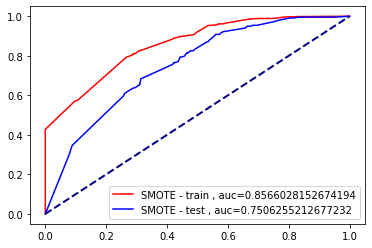

In [49]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

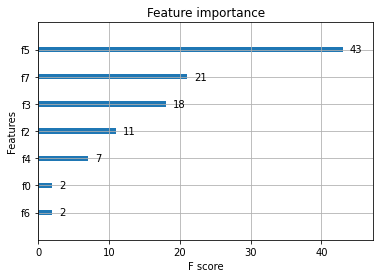

In [50]:
xgb.plot_importance(xgb_model_SMOTE)

In [51]:
print('XGBoost model - SMOTE - parameter tuning')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc",
 base_score=0.5,
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.4,
 colsample_bytree=0.4,
 nthread=4)
predicted_y = []
expected_y = []

xgb_model_SMOTE_tuned = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE_tuned.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('XGBoost model - SMOTE - parameter tuning')
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_tuned.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE - parameter tuning
[0]	validation_0-auc:0.728758
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.74073
[2]	validation_0-auc:0.738804
[3]	validation_0-auc:0.70633
[4]	validation_0-auc:0.707308
[5]	validation_0-auc:0.708666
[6]	validation_0-auc:0.708902
Stopping. Best iteration:
[1]	validation_0-auc:0.74073

XGBoost model - SMOTE - parameter tuning
training set
              precision    recall  f1-score   support

           0       0.81      0.65      0.72      4389
           1       0.71      0.85      0.77      4389

    accuracy                           0.75      8778
   macro avg       0.76      0.75      0.74      8778
weighted avg       0.76      0.75      0.74      8778

test set
              precision    recall  f1-score   support

           0       0.95      0.65      0.77      1848
           1       0.19      0.70      0.30       218

    accuracy                           0.65      2066
   macro avg       0.57 